In [32]:
## Find overlapping data between ICESat-2 and Sentinel-2
import os
import pandas as pd
from pykml import parser
from datetime import datetime, timedelta

def get_S2_files(path):
    # Get all the Sentinel 2 files in the directory
    files = []
    for year in os.listdir(path):
        for month in os.listdir(path+"/"+year):
            for file in os.listdir(path+"/"+year+"/"+month):
                files.append(path+"/"+year+"/"+month+"/"+file)
    return files

def get_path_by_date(files, date):  
    # Get the path of the Sentinel 2 file by date
    # date: "YYYYMMDD"
    if "IS2" in files[0]:
        date = convert_date(date)
        print(date)
    path = [file for file in files if date in file]
    return path

def get_ICESat2_files(path):
    # Get all the ICESat-2 files in the directory
    files = []
    for file in os.listdir(path):
        files.append(path+"/"+file)
    return files

def open_S2_files(path):
    # Open the Sentinel 2 files
    with open(path, "r") as f:
        data = pd.read_csv(f, sep=";")
        df = pd.DataFrame(data)
        df.drop_duplicates(subset=["Id"])
    return df

def convert_date(date):
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    months = {
        '01': 'Jan',
        '02': 'Feb',
        '03': 'Mar',
        '04': 'Apr',
        '05': 'May',
        '06': 'Jun',
        '07': 'Jul',
        '08': 'Aug',
        '09': 'Sep',
        '10': 'Oct',
        '11': 'Nov',
        '12': 'Dec'
    }
    return f"{day}-{months[month]}-{year}"

def open_ICESat2_df(path,bbox):
    os.getcwd()+"/"+path
    lon_min,lon_max,lat_min,lat_max = bbox
    
    with open(path, 'r') as f:
        try:
            doc = parser.parse(f)
            # Get points from the kml file
            Doc = doc.getroot().Document
        except:
            return None

        Point_t, Lat_t, Lon_t = [], [], []
        for Folder in Doc.Folder:
            format_string = "%d-%b-%Y %H:%M:%S"
            time_string = " ".join(Folder.name.text.split(" ")[3:])
            
            datetime_object = datetime.strptime(time_string, format_string)

            Point_t.append(datetime_object)
            #print(datetime_object)
            coords = Folder.Placemark.Point.coordinates.text.split(",")
            Lon,Lat = float(coords[0]), float(coords[1])
            Lat_t.append(Lat)
            Lon_t.append(Lon)

        if len(Point_t) == 0:
            return None
        
        # Get coordinates from flight path
        start_time = Point_t[0]
        end_time = Point_t[-1]
        
        coords = doc.getroot().Document.Placemark.LineString.coordinates.text
        coords = coords.split(",0 ")
        lon, lat = [float(x.split(',')[0]) for x in coords[:-1]], [float(x.split(',')[1]) for x in coords[:-1]]
        # Interpolate time from points to flight path
        interval = (end_time - start_time) / (len(lon)-1) #Smart her antages lige tid mellem kordinat.

        flight_path_df = pd.DataFrame({"time":[start_time + i*interval for i in range(len(lon))],'lat':lat,'lon':lon})
        flight_path_df = flight_path_df[(flight_path_df["lat"] > lat_min) & (flight_path_df["lon"] >lon_min) & (flight_path_df["lon"]<lon_max)]  
        Point_df = pd.DataFrame({'time':Point_t,'Lat':Lat_t,'Lon':Lon_t})
        Point_df = Point_df[(Point_df["Lat"] > lat_min) & (Point_df["Lon"] >lon_min) & (Point_df["Lon"]<lon_max)]
        Point_df["Icesat_name"] = path.split("/")[-1]
        f.close()
    
    return flight_path_df 

In [33]:
pathA,pathB = os.getcwd()+"/S2A",os.getcwd()+"/S2B"
S2_files = get_S2_files(pathA) + get_S2_files(pathB)

path_ICESat2 = os.getcwd()+"/ICESat_2"
ICESat2_files = get_ICESat2_files(path_ICESat2)
print(len(ICESat2_files))

# date = "20200701"
# S2_path = get_path_by_date(S2_files, date)
# Ice_path = get_path_by_date(ICESat2_files, date)
# print(S2_path)
# print(Ice_path)


12318


In [34]:
from shapely.geometry import Polygon,Point
from shapely.wkt import loads
import geopandas as gpd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

def plot_map(sentinel_dfs,icesat_dfs,extent):
    # Plot the polygons and the world map
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines()

    # Create a GeoDataFrame from the polygon
    for df in sentinel_dfs:
        gdf = gpd.GeoDataFrame(df,geometry=df['geometry'])
        gdf.crs = 'EPSG:3031'
        gdf.plot(ax=ax,transform=ccrs.PlateCarree())

    for i in icesat_dfs:
        if i.empty:
            continue
        else:
            geometry = [Point(xy) for xy in zip(i['lon'], i['lat'])]
            geo_df = gpd.GeoDataFrame(i, geometry=geometry)
            geo_df.crs = "EPSG:3031"
            geo_df.plot(ax=ax, color='red',transform=ccrs.PlateCarree())

    # Set the title and show the plot
    ax.set_title('Polygons with Stereographic Projection')
    plt.show()



In [35]:
# Define the specific area coordinates
lat_min = 70
lat_max = 90
lon_min = -140
lon_max = -50

bbox = [lon_min,lon_max,lat_min,lat_max]

def return_gpdS2(dfs,bbox):
    if dfs == []:
        return None
    lon_min,lon_max,lat_min,lat_max = bbox
    gdfs = []
    for df in dfs:
        #print(len(df))
        df.dropna(subset=['Bbox'], inplace=True)
        df.loc[df["Name"].str.contains("MSIL2A"), :]
        df.loc[:, 'geometry'] = df['Bbox'].apply(loads)
        df["geometry"] = df["geometry"].apply(lambda x: x if x.bounds[1] > lat_min and x.bounds[3] < lat_max and x.bounds[0] > lon_min and x.bounds[2] < lon_max else None)
        df.dropna(subset=['geometry'], inplace=True)
        df["start"] = pd.to_datetime(df["ContentDate:Start"])
        df["end"] = pd.to_datetime(df["ContentDate:End"])
        df.reset_index(drop=True, inplace=True)
        #print(len(df))
        gdfs.append(df)
    gdfS2 = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    gdfS2.geometry = gdfS2["geometry"]
    gdfS2.crs = 'EPSG:3031'
    return gdfS2

#print(return_gpdS2([open_S2_files(i) for i in S2_path],bbox))

def return_gpdIce(dfs,bbox):
    if dfs == []:
        return None
    lon_min,lon_max,lat_min,lat_max = bbox
    gdfs = []
    for df in dfs:
        if df is None:
            continue
        else:
            df = df[(df["lat"] > lat_min) & (df["lon"] > lon_min) & (df["lon"] < lon_max)]
            df["geometry"] = [Point(xy) for xy in zip(df['lon'], df['lat'])]
            df["time"] = pd.to_datetime(df["time"])
            df.reset_index(drop=True, inplace=True)
            gdfs.append(df)

    gdfIce = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    gdfIce.crs = 'EPSG:3031'
    gdfIce.geometry = gdfIce["geometry"]
    return gdfIce


False


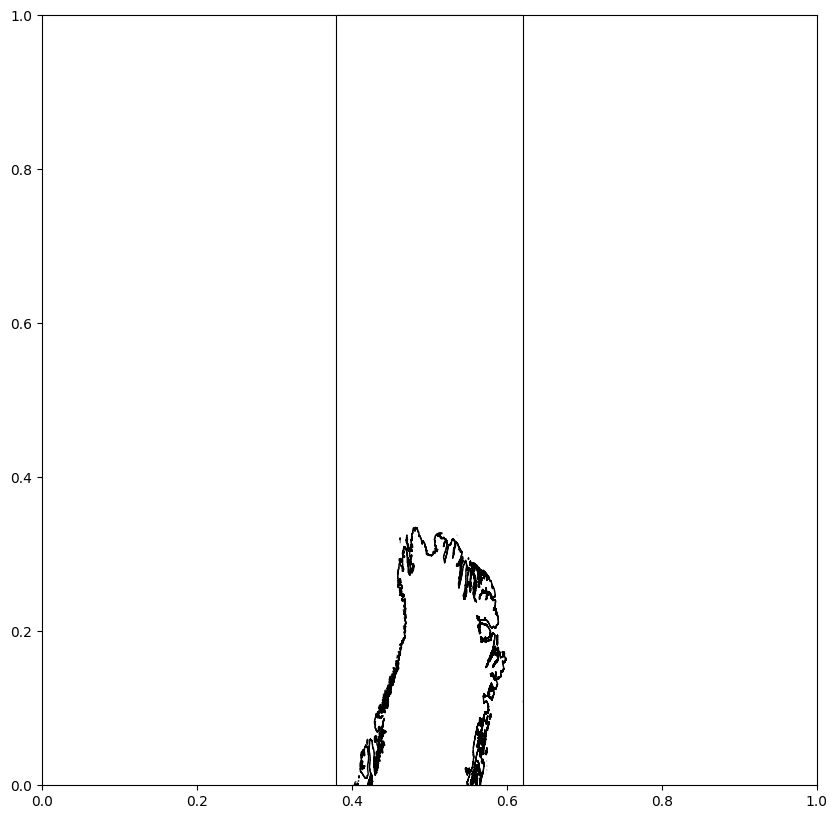

In [36]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

#### HER LOADER TESTER JEG OM GRØNLANDSKORTET VIRKER

# Load the shapefile
shapefile_path = 'greenland/GRL_adm0.shp'
gdf = gpd.read_file(shapefile_path)

# Convert the shapefile to a polygon
polygon = gdf.geometry.iloc[0]

# Create a point
point = Point(-10, 80)  # Replace lon and lat with the coordinates of your point

# Check if the point is in the polygon
is_in_polygon = polygon.contains(point)

print(is_in_polygon)

fig, ax = plt.subplots(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.set_extent(bbox, ccrs.PlateCarree())

# Plot the shapefile on a map
gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Show the plot
plt.show()


In [37]:
from datetime import datetime, timedelta

def find_overlap(S2_gdf,ICE_gdf,time_delta = timedelta(hours=1)):
    spacial_join = gpd.sjoin(S2_gdf,ICE_gdf,how="inner",predicate="intersects")
    spacial_join.drop_duplicates()
    spacial_join.reset_index(drop=True, inplace=True)

    spacial_join["time_diff"] = abs(spacial_join["start"] - spacial_join["time"])
    spacial_join = spacial_join[spacial_join["time_diff"] <= time_delta]

    return spacial_join

# Define the time period
start_date = datetime(2019, 6, 20)
end_date = datetime(2019, 6,26)

current_date = start_date
overlap = []

for i in range((end_date - start_date).days):
    date_str = current_date.strftime("%Y%m%d")
    print(date_str)
    S2_path = get_path_by_date(S2_files, date_str)
    Ice_path = get_path_by_date(ICESat2_files, date_str)
    print(S2_path,Ice_path)
    if len(S2_path) == 0 or len(Ice_path) == 0:
        current_date += timedelta(days=1)
        pass
    else:
        S2_gdf = return_gpdS2([open_S2_files(i) for i in S2_path],bbox)
        ICE_gdf = return_gpdIce([open_ICESat2_df(i,bbox) for i in Ice_path],bbox)
        overlap_data = find_overlap(S2_gdf,ICE_gdf)
        if overlap_data is not None:
            overlap.append(overlap_data)
            print(date_str,len(overlap[-1]))
        else:
            print(date_str)
            
        current_date += timedelta(days=1)


overlap = pd.concat(overlap, ignore_index=True)
if overlap.empty:
    print("No overlap")
else:
    print(overlap.iloc[overlap["time_diff"].idxmin()])


20190620
20-Jun-2019
['c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/S2A/2019/06/S2A_20190620_COPERNICUS_catalogue_20240208132708.csv', 'c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/S2B/2019/06/S2B_20190620_COPERNICUS_catalogue_20240208132708.csv'] ['c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/ICESat_2/IS2_RGT_1264_cycle3_20-Jun-2019.kml', 'c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/ICESat_2/IS2_RGT_1265_cycle3_20-Jun-2019.kml', 'c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/ICESat_2/IS2_RGT_1266_cycle3_20-Jun-2019.kml', 'c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/ICESat_2/IS2_RGT_1267_cycle3_20-Jun-2019.kml', 'c:\\Users\\holge\\OneDrive - Danmarks Tekniske Universitet\\30110 Fagprojekt\\Getdata/ICESat_2/IS2_RGT_1268_cycle3_20-Jun-2019.kml',

In [38]:
def filter_polygons(df, bbox):
    # Create a Polygon representing the bbox
    bbox_polygon = Polygon([
        (bbox[0], bbox[2]),
        (bbox[1], bbox[2]),
        (bbox[1], bbox[3]),
        (bbox[0], bbox[3]),
        (bbox[0], bbox[2])
    ])
    polygon = gpd.GeoDataFrame(index=[0], crs='EPSG:3031', geometry=[bbox_polygon])

    # Filter polygons in the DataFrame
    filtered_df = gpd.sjoin(df, polygon, how='inner', predicate='intersects')

    return filtered_df

### FIND OVERLAP BETWEEN ICESAT AND SENTINEL DATA, WITH NO OVERLAP OF GREENLAND AND CANADA
greenland = gpd.read_file('greenland/GRL_adm0.shp')
greenland.crs = 'EPSG:3031'
canada = gpd.read_file('canada/CAN_adm0.shp')
canada.crs = 'EPSG:3031'

greenland = filter_polygons(greenland, bbox)
canada = filter_polygons(canada, bbox)

print(len(overlap))
overlap_copy = overlap.drop(columns=["index_right"])
canada = canada.drop(columns=["index_right"])
greenland = greenland.drop(columns=["index_right"])
overlap_copy["geometry"] = [Point(xy) for xy in zip(overlap['lon'], overlap['lat'])]
intersection = gpd.sjoin(overlap_copy, greenland, how="inner", predicate="intersects")
overlap_copy = overlap_copy[~overlap_copy.index.isin(intersection.index)]
intersection = gpd.sjoin(overlap_copy, canada, how="inner", predicate="intersects")
overlap_copy = overlap_copy[~overlap_copy.index.isin(intersection.index)]

overlap_copy.sort_values(by="time", inplace=True)

overlap_copy.to_csv('overlap_copy.csv', index=False)

print(len(overlap_copy))


## PLOT AF ICESAT OG SENTINEL DATA MED GRØNLAND OG CANADA

# overlap_df.crs = 'EPSG:3031'
# overlap_df = gpd.sjoin(overlap_df, greenland, how="inner", op="intersects")

# fig, ax = plt.subplots(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
# ax.set_extent(bbox, ccrs.PlateCarree())
# ax.coastlines()
# # Plot the shapefile on a map
# greenland.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='green')
# canada.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='yellow')
# overlap.geometry = overlap['geometry']
# overlap.plot(ax=ax, color='red',transform=ccrs.PlateCarree(),markersize=1)
# overlap.geometry = [Point(xy) for xy in zip(overlap['lon'], overlap['lat'])]
# overlap.plot(ax=ax, color='blue',transform=ccrs.PlateCarree(),markersize=1)

# overlap_copy.plot(ax=ax, color='pink',transform=ccrs.PlateCarree(),markersize=1)
# plt.show()


2655
1259
